# The American Pika (Ochotona princeps) Climate Migration

[The American Pika](https://en.wikipedia.org/wiki/American_pika) (or Pika for short) is a beloved mountain mammal that lives at or above tree line, typically in boulder fields. These small creatures are distant relatives of rabbits but much, much smaller. They are considered incredibly cute by those who have the luck of spotting one. Often, they are heard before they are seen because they are extremely vocal. Their distinctive chirp reverberates throughout the high-altitude rock faces across the western U.S.

## Pikas and Climate Change
Pikas live in the colder temperatures of the western U.S. high country. They are adapted to the lower temperatures that come with high altitudes and hibernate deep in the rocks and under snowpack through the winter. As a result, global warming impacts Pikas in two ways: 1) reduced snowpack in winter and 2) temperatures too hot to sustain in summer. Pikas can experience heat stroke at only 77 degrees F!

These temperature changes have resulted in a declining population. Fieldwork shows that Pikas have begun an elevation migration to mitigate these changes. In other words, Pikas are moving to higher altitudes to find cooler temperatures. The [Pika Project](https://pikapartners.org/about-the-project/), a community science program aiming to better understand the Pika population in Colorado, points out that site elevations in Nevada and southern Oregon have risen up to 900 feet.

### Can Community Observations from the GBIF Provide Insight into the Pika Climate Migration?
The [Global Biodiversity Information Facility](https://www.gbif.org/) (GBIF) is a database of life on earth. With GBIF, we can easily access observation occurrences of the American Pika, including their location. Given a Pika observation location (latitude and longitude), we can determine the elevation at which the Pika was spotted using an open-access Digital Elevation Model (DEM). Since Pika primarily live above tree line and tree line varies widely by region we need to also correct for region. to do this we will use defined ecoregions. Finally, we can separate the data by month and average the elevation for each year. The year on year trend can then be plotted.

Current live Pika observations date back to the early 2000s, and observations have increased rapidly since then. Challenges in this approach include a strong bias toward more recent Pika observations compared to the early 2000s. Furthermore, noticeable global temperature changes were already present in the late 1900s, which cannot be captured in this dataset.


### Import required libraries

In [277]:
%%bash
pip install pygbif

In [278]:
import cartopy.crs as ccrs
import geopandas as gpd
import geoviews
from glob import glob
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import pandas as pd
import panel as pn
import pathlib
import pygbif.occurrences as occ
import pygbif.species as species
import requests
import time
import zipfile

from getpass import getpass


## Download and wrangle the ecoregions shape files from Google APIs

In [279]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'Pika_distribution',
)
#data_dir
os.makedirs(data_dir, exist_ok=True)

In [280]:
# Set up the ecoregion boundary URL
eco_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
re_dir = os.path.join(data_dir, 'resolve_ecoregions')

#Make the shape file directory. 
os.makedirs(re_dir, exist_ok=True)

# Join ecoregions shapefile path
eco_shp_path = os.path.join(re_dir, 'ecoregions.shp')

# Only download once
if not os.path.exists(eco_shp_path):
    eco_gdf = gpd.read_file(eco_url)
    eco_gdf.to_file(eco_shp_path)

In [281]:
# Open up the ecoregions boundaries
eco_gdf = (
    gpd.read_file(eco_shp_path)
    [['OBJECTID', 'ECO_NAME', 'SHAPE_AREA', 'geometry']]
    .rename(columns={
        'OBJECTID': 'ecoregion_id',
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'
    })
    .set_index('ecoregion_id')
)

eco_gdf

,name,area,geometry
ecoregion_id,,,
1.0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
2.0,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
3.0,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
4.0,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
5.0,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...
848.0,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
212.0,East African montane forests,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
224.0,Eastern Arc forests,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


## Download and wrangle American Pika observation data from GBIF

In [282]:
#Locate and define the gbif datafram
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'pika_distribution',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'gbif_pika_data')
gbif_pattern = os.path.join(gbif_dir, '*.csv')
gbif_path = glob(gbif_pattern)[0]

# Query species
species_info = species.name_lookup('Ochotona princeps', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key


('Ochotona princeps', 2436982)

#### Here, we download the GBIF data for the American Pika

* Data is downloaded between 1980 and 2023
* If the data already exists locally, the download request is skipped


In [283]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f"speciesKey = { species_key }",
            "hasCoordinate = True",
            "year = 1980,2023",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]
gbif_path

'C:\\Users\\zachn\\earth-analytics\\data\\pika_distribution\\gbif_pika_data\\0007501-241024112534372.csv'

In [284]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID', 'month', 'year', 'decimalLatitude', 'decimalLongitude', 'elevation']
)
gbif_df.head()

,decimalLatitude,decimalLongitude,elevation,month,year
gbifID,,,,,
923923961,40.587348,-111.617097,NaN,6.0,2014
923922049,40.543289,-111.692180,NaN,6.0,2014
923921599,37.912662,-119.265777,NaN,6.0,2014
911507490,48.000988,-121.424204,NaN,6.0,2014
911496161,47.751074,-120.740139,NaN,7.0,1992


#### Note above that elevation is included as a data column, but the information is NaN

## Download and wrangle the elevation data

Elevation data is obtained from the [Open Topo Data API](https://www.opentopodata.org/). To do so requires some modification to the dataset and it has some limitations. Only 100 locations can be requested at a time and onle 100 requests can be made per day. Further, including 100 lat lon pairs in a single URL introduces additional length limits. There is also a required 1 sec wait between requests. Finally, the elevation resolution is 30 m, which is nearly 100 ft. This could be improved to 8 m if only the U.S. is considered but we choose to include Canada here. As such the following is done to manage these limitations. 
* The observed lat lon pairs are rounded to 2 decimal places. This reduces accuracy, but is likely well within the 30 m elevation resolution. 
* The dataset is chopped into groups of 100 for inidivual requests.
* If the elevation dataset is already available locally, additional requests are not made. 
* There is a 2 second wait between each request. 

In [285]:
#Round the lat and lon data to be used for elevation requests.
gbif_df_rounded = gbif_df 
gbif_df_rounded['decimalLatitude'] = (
    gbif_df_rounded['decimalLatitude']
    .round(2)
)

gbif_df_rounded['decimalLongitude'] = (
    gbif_df_rounded['decimalLongitude']
    .round(2)
)

print(gbif_df_rounded)


            decimalLatitude  decimalLongitude  elevation  month  year
gbifID                                                               
923923961             40.59           -111.62        NaN    6.0  2014
923922049             40.54           -111.69        NaN    6.0  2014
923921599             37.91           -119.27        NaN    6.0  2014
911507490             48.00           -121.42        NaN    6.0  2014
911496161             47.75           -120.74        NaN    7.0  1992
...                     ...               ...        ...    ...   ...
1024188695            41.36           -122.19        NaN    7.0  2014
1024184546            40.54           -111.68        NaN    7.0  2014
1024183578            37.85           -107.77        NaN    6.0  2014
1019052694            40.62           -115.38        NaN    8.0  1998
1019052661            40.62           -115.38        NaN    8.0  1998

[7508 rows x 5 columns]


In [286]:
# Define a function to pull elevation data via Open Topo API
def get_altitudes(df):
    # Prepare the locations as a string
    locations_str = (
        "|".join([
            f"{row['decimalLatitude']},{row['decimalLongitude']}" 
            for _, row in df.iterrows()
        ])
    )

    # Dataset resolution and location
    elev_dataset = "srtm30m"

    # Open Topo Data API endpoint
    url = (
        f"https://api.opentopodata.org/v1/{elev_dataset}"
        f"?locations={locations_str}"
    )

    # Make a request to the Open Topo Data API
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the response JSON data
        data = response.json()
        
        # Add the elevation data to the DataFrame
        df['elevation'] = [result['elevation'] for result in data['results']]
        return df
    else:
        print(f"Failed to connect, status code: {response.status_code}")
        return None
    
#Define a function to split the dataset into chuncks of 100 per request
def split_dataframe(gbif_df, chunk_size=100):
    for i in range(0, gbif_df.shape[0], chunk_size):
    #for i in range(0, 99, chunk_size):
        yield gbif_df.iloc[i:i + chunk_size]


In [287]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, 'Lat_Lon_Elev_M_Y.csv')
if not glob(gbif_pattern):
    #Temporary storage of chuncked elevations to be added back to a dataframe
    chunk_list = []

    # Process data in chunks of 100
    # splits the data frame and iteratively requests the altitudes
    for df_chunk in split_dataframe(gbif_df, chunk_size=100):
        df_chunk_with_altitudes = get_altitudes(df_chunk)

    #Append the processed chunk to the list
        chunk_list.append(df_chunk_with_altitudes)
        
        #Add a delay between API requests to avoid rate penalty
        time.sleep(2)

    gbif_df_wAltitude = pd.concat(chunk_list, ignore_index=True)

    # Save the bgif_df_wAltitude as csv
    gbif_df_wAltitude.to_csv(gbif_dir+"\Lat_Lon_Elev_M_Y.csv")

    #Lost the index with altitude somehow
    gbif_df_wAltitude.index = gbif_df.index

gbif_df_wAltitude



C:\Users\zachn\AppData\Local\Temp\ipykernel_15520\3879868582.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elevation'] = [result['elevation'] for result in data['results']]


,decimalLatitude,decimalLongitude,elevation,month,year
gbifID,,,,,
923923961,40.59,-111.62,2781.0,6.0,2014
923922049,40.54,-111.69,3049.0,6.0,2014
923921599,37.91,-119.27,3152.0,6.0,2014
911507490,48.00,-121.42,816.0,6.0,2014
911496161,47.75,-120.74,620.0,7.0,1992
...,...,...,...,...,...
1024188695,41.36,-122.19,2427.0,7.0,2014
1024184546,40.54,-111.68,3041.0,7.0,2014
1024183578,37.85,-107.77,3516.0,6.0,2014


In [288]:
#Convert gbif data to a geodataframe
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df_wAltitude, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'year', 'elevation', 'geometry']]
)

gbif_gdf


,month,year,elevation,geometry
gbifID,,,,
923923961,6.0,2014,2781.0,POINT (-111.62 40.59)
923922049,6.0,2014,3049.0,POINT (-111.69 40.54)
923921599,6.0,2014,3152.0,POINT (-119.27 37.91)
911507490,6.0,2014,816.0,POINT (-121.42 48)
911496161,7.0,1992,620.0,POINT (-120.74 47.75)
...,...,...,...,...
1024188695,7.0,2014,2427.0,POINT (-122.19 41.36)
1024184546,7.0,2014,3041.0,POINT (-111.68 40.54)
1024183578,6.0,2014,3516.0,POINT (-107.77 37.85)


In [289]:
#Combine the ecoregions and gbif data
gbif_ecoregions_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
)

gbif_ecoregions_gdf

,name,area,geometry,gbifID,month,year,elevation
ecoregion_id,,,,,,,
74.0,Blue Mountains forests,8.066966,"POLYGON ((-116.73108 46.26653, -116.72977 46.2...",4947687918,8.0,1981,1284.0
74.0,Blue Mountains forests,8.066966,"POLYGON ((-116.73108 46.26653, -116.72977 46.2...",1145299529,8.0,1988,2591.0
74.0,Blue Mountains forests,8.066966,"POLYGON ((-116.73108 46.26653, -116.72977 46.2...",1132402468,6.0,2015,1362.0
74.0,Blue Mountains forests,8.066966,"POLYGON ((-116.73108 46.26653, -116.72977 46.2...",1145266936,8.0,2005,2291.0
74.0,Blue Mountains forests,8.066966,"POLYGON ((-116.73108 46.26653, -116.72977 46.2...",1145266930,8.0,2005,2344.0
...,...,...,...,...,...,...,...
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",3996587399,9.0,2009,1065.0
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",4600166120,5.0,2022,1868.0
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",2013009035,8.0,2017,1633.0


### Next we will seperate the data by month and average the elevation.

Now that we have the observed locations and calculated elevations grouped by different ecoregions we will create seperate datasets by month. Dividing these datasets by month corrects for differences in snowpack and observational differences month to month. 

In [290]:
#Only consider individual months July, Aug, Sep. 
gbif_ecoregions_gdf_Jul = gbif_ecoregions_gdf[gbif_ecoregions_gdf['month'] == 7]
gbif_ecoregions_gdf_Aug = gbif_ecoregions_gdf[gbif_ecoregions_gdf['month'] == 8]
gbif_ecoregions_gdf_Sep = gbif_ecoregions_gdf[gbif_ecoregions_gdf['month'] == 9]
gbif_ecoregions_gdf_Smr = gbif_ecoregions_gdf[gbif_ecoregions_gdf['month'].isin([7, 8, 9])]


In [291]:
#Count observations and average elvation for each month
mean_elevation_df_Jul = (
    gbif_ecoregions_gdf_Jul
    .reset_index()  # Reset index for the final DataFrame
    .groupby(['ecoregion_id', 'year', 'month'])
    .agg(
        elevation_mean=('elevation', 'mean'),  # Calculate mean elevation first
        occurrences=('gbifID', 'count'),       # Count occurrences
        area=('area', 'first')                 # Take the first value of area
    )
    
)

#Count observations and average elvation for each month
mean_elevation_df_Aug = (
    gbif_ecoregions_gdf_Aug
    .reset_index()  # Reset index for the final DataFrame
    .groupby(['ecoregion_id', 'year', 'month'])
    .agg(
        elevation_mean=('elevation', 'mean'),  # Calculate mean elevation first
        occurrences=('gbifID', 'count'),       # Count occurrences
        area=('area', 'first')                 # Take the first value of area
    )
    
)

#Count observations and average elvation for each month
mean_elevation_df_Sep = (
    gbif_ecoregions_gdf_Sep
    .reset_index()  # Reset index for the final DataFrame
    .groupby(['ecoregion_id', 'year', 'month'])
    .agg(
        elevation_mean=('elevation', 'mean'),  # Calculate mean elevation first
        occurrences=('gbifID', 'count'),       # Count occurrences
        area=('area', 'first')                 # Take the first value of area
    )
    
)

#Count observations and average elvation for each month
mean_elevation_df_Smr = (
    gbif_ecoregions_gdf_Smr
    .reset_index()  # Reset index for the final DataFrame
    .groupby(['ecoregion_id', 'year', 'month'])
    .agg(
        elevation_mean=('elevation', 'mean'),  # Calculate mean elevation first
        occurrences=('gbifID', 'count'),       # Count occurrences
        area=('area', 'first')                 # Take the first value of area
    )
    
)


In [292]:
# Get rid of rare observations 
mean_elevation_df_Jul = mean_elevation_df_Jul[mean_elevation_df_Jul.occurrences>3]
mean_elevation_df_Aug = mean_elevation_df_Aug[mean_elevation_df_Aug.occurrences>3]
mean_elevation_df_Sep = mean_elevation_df_Sep[mean_elevation_df_Sep.occurrences>3]
mean_elevation_df_Smr = mean_elevation_df_Smr[mean_elevation_df_Smr.occurrences>3]

#pd.set_option('display.max_rows', None)
#print(mean_elevation_df_Jul)
#pd.reset_option('display.max_rows')

#### To help with plotting, we will normalize the elevation by the average elevation across the 2000-2020 period.

Normalizing the elevation in each ecoregion will allow the results to be plotted together. In this normalization, any value greater than one is above the average elvation and any value less than one is below the average elevation.

From here on, we will focus only on the month of July as the results across all months are similar. However, considering the data above, it appears that there is large variability month to month so keeping them seperate may still be appropriate. 

In [293]:
# Normalize elevation to the 2000 - 2020 average within each ecoregion
mean_elevation_df_Jul_norm = (
    mean_elevation_df_Jul
        .reset_index()
        .groupby('ecoregion_id')['elevation_mean']
        .mean()
)

mean_elevation_df_Jul['rel_elevation'] = (
    mean_elevation_df_Jul['elevation_mean'] 
    / mean_elevation_df_Jul_norm
)

#Reset the index such that year is not an index
#Doing so helps with plotting
# Transfer the year and month to columns
mean_elevation_df_Jul = (
    mean_elevation_df_Jul
        .reset_index(level = ['year', 'month'])
)

mean_elevation_df_Jul_rdcd = (
    mean_elevation_df_Jul[['year', 'rel_elevation']]
)


In [294]:
# Normalize elevation to the 2000 - 2020 average within each ecoregion
mean_elevation_df_Aug_norm = (
    mean_elevation_df_Aug
        .reset_index()
        .groupby('ecoregion_id')['elevation_mean']
        .mean()
)

#mean_elevation_df_Aug_temp = mean_elevation_df_Aug.merge(mean_elevation_df_Aug_norm, on='ecoregion_id')

mean_elevation_df_Aug['rel_elevation'] = (
    mean_elevation_df_Aug['elevation_mean'] 
    / mean_elevation_df_Aug_norm
)

# Transfer the year and month to columns
mean_elevation_df_Aug = (
    mean_elevation_df_Aug
        .reset_index(level = ['year', 'month'])
)

mean_elevation_df_Aug_rdcd = (
    mean_elevation_df_Aug[['year', 'rel_elevation']]
)

pd.set_option('display.max_rows', None)
print(mean_elevation_df_Aug_rdcd)
pd.reset_option('display.max_rows')

              year  rel_elevation
ecoregion_id                     
74.0          1987       0.938273
74.0          1988       1.109062
74.0          2004       1.031479
74.0          2005       0.992575
74.0          2019       0.945892
74.0          2022       0.982718
83.0          1988       0.837389
83.0          2021       1.188530
83.0          2023       0.974081
125.0         1990       1.439609
125.0         2004       0.820556
125.0         2005       0.990073
125.0         2013       0.940260
125.0         2014       1.085480
125.0         2015       0.892826
125.0         2016       1.098001
125.0         2017       1.058699
125.0         2018       0.875644
125.0         2019       0.958513
125.0         2020       0.926401
125.0         2021       0.880662
125.0         2022       1.017297
125.0         2023       1.015978
175.0         1985       0.979305
175.0         1987       0.940043
175.0         1990       0.869115
175.0         1991       0.844390
175.0         

### Finally, we begin plotting

In [295]:
# Prepare to plot on a map

#Duplicate the geo data frame
eco_gdf_smp = eco_gdf
# Simplify the geometry to speed up processing
eco_gdf_smp.geometry = eco_gdf_smp.simplify(0.1, 
    preserve_topology=False)

# Change the CRS to Mercator for mapping
eco_gdf_crs = eco_gdf_smp.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
#eco_gdf_smp.hvplot(geo=True, crs=ccrs.Mercator())

In [296]:
# Join the occurrences with the plotting GeoDataFrame
melevation_gdf_Jul = eco_gdf_crs.join(mean_elevation_df_Jul_rdcd[['rel_elevation', 'year']])

# Remove rows (eco regions) which do not have a relative elevation
melevation_gdf_Jul = melevation_gdf_Jul.dropna()


# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = gbif_gdf.to_crs(ccrs.Mercator()).total_bounds

#Set the color scale bounds
z_min = mean_elevation_df_Jul_rdcd['rel_elevation'].min()  # Set your desired minimum value
z_max = mean_elevation_df_Jul_rdcd['rel_elevation'].max()  # Set your desired maximum value

#Create the widget
year_widget = pn.widgets.DiscreteSlider(
    name='Year',
    options=sorted(melevation_gdf_Jul['year'].unique().tolist()),  # Set available years
    value=sorted(melevation_gdf_Jul['year'].unique().tolist())[0]  # Optionally set the default value
)

# Plot occurrence by ecoregion and month
migration_plot = (
    melevation_gdf_Jul
    .hvplot(
        c='rel_elevation',
        groupby='year',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Pika Migration",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        clim=(z_min, z_max),
        frame_height=600,
        widgets={'Year' : year_widget},
        widget_location='bottom'
    )
)

#melevation_gdf_Jul

# Save the plot
migration_plot.save('migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'1df84984-4e63-44ac-9c8e-d00be59db1cb': {'version…

### There appears to be no clear trend in elevation in any ecoregion year on year. 

Scrolling through the individual years shows minimal change in the relative average yearly elevation (colorscale). Even more, there is no apparent trend in the yearly elevation change. Below, we can plot all ecoregions together on a line plot to make the lack of a trend more clear. 

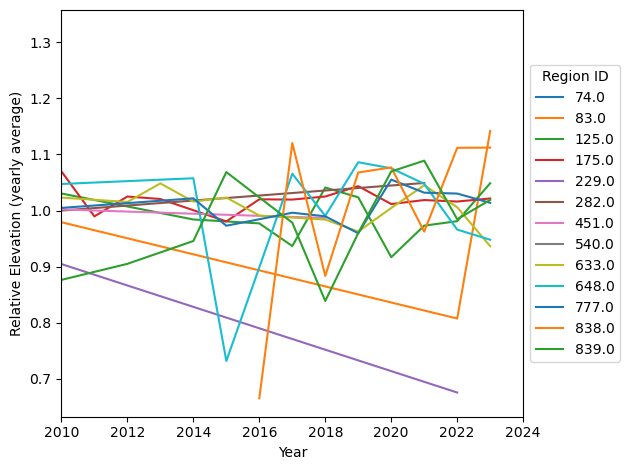

In [297]:
# Group by the index and plot each group
fig, ax = plt.subplots()
for name, group in mean_elevation_df_Jul_rdcd.groupby(mean_elevation_df_Jul_rdcd.index):
    # Plot x vs. y for each index group
    ax.plot(group['year'], group['rel_elevation'], label=name)  

ax.set_xlim([2010, 2024])
ax.set_xlabel('Year')
ax.set_ylabel('Relative Elevation (yearly average)')
ax.legend(
    title='Region ID',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.tight_layout()
plt.show()

The above plot shows there is large variability in the average elevation year to year. 

## The Above Approach is Unable to Reveal Clear Trends in Pika Climate Migration

The above approach shows that there is large year-to-year variation in the average elevation for an individual month (not shown) and ecoregion. In all regions, there is sparse observational data before 2010, which limits the ability to compare the last decade of data with a reference set. A reference to an earlier period, ideally pre-1980, would be ideal. It may be the case that the change in average Pika elevation is too small over the last decade to be discerned within the observational variability. In some ecoregions, there are consistent observations within the last decade (e.g., ID 839). Even so, the trend is roughly flat in these cases.

More precise data filtering could improve the result. For example, filtering observations within specific wilderness areas or even mountains may reveal clearer trends. It is possible that some colonies of Pika may reside at different elevations within an ecoregion due to landscape constraints (e.g., location of boulder fields). Reducing the investigation to individual colonies may be more appropriate. At the same time, however, reducing the region size may not be possible with the current amount of annual observations.



